In [2]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
%matplotlib inline

In [3]:
def make_mini_batch(train_data, size_of_mini_batch, length_of_sequences):
    inputs  = np.empty(0)
    outputs = np.empty(0)
    print(train_data[0:60])
    for _ in range(size_of_mini_batch):
        index   = random.randint(0, len(train_data) - length_of_sequences)
        print("make_mini_batch: {}".format(index))
        part    = train_data[index:index + length_of_sequences]
        inputs  = np.append(inputs, part[:, 0])
        outputs = np.append(outputs, part[-1, 1])
    inputs  = inputs.reshape(-1, length_of_sequences, 1)
    outputs = outputs.reshape(-1, 1)
    return (inputs, outputs)

In [4]:
def make_prediction_initial(train_data, index, length_of_sequences):
    return train_data[index:index + length_of_sequences, 0]

In [4]:
train_data_path             = "./xsinx.npy"
num_of_input_nodes          = 1
num_of_hidden_nodes         = 10
num_of_output_nodes         = 1
length_of_sequences         = 10
num_of_training_epochs      = 800
length_of_initial_sequences = 10
num_of_prediction_epochs    = 100
size_of_mini_batch          = 100
learning_rate               = 0.1
forget_bias                 = 1.0

In [30]:
train_data = np.load(train_data_path)
#print("train_data:", train_data)
train_data[0:20]

array([[  0.        ,   0.12533323],
       [  0.12533323,   0.49737977],
       [  0.49737977,   1.10437366],
       [  1.10437366,   1.9270147 ],
       [  1.9270147 ,   2.93892626],
       [  2.93892626,   4.10728264],
       [  4.10728264,   5.3935927 ],
       [  5.3935927 ,   6.7546234 ],
       [  6.7546234 ,   8.14344347],
       [  8.14344347,   9.51056516],
       [  9.51056516,  10.80515976],
       [ 10.80515976,  11.97632074],
       [ 11.97632074,  12.97434747],
       [ 12.97434747,  13.75202151],
       [ 13.75202151,  14.26584774],
       [ 14.26584774,  14.47723284],
       [ 14.47723284,  14.35357473],
       [ 14.35357473,  13.86923837],
       [ 13.86923837,  13.00639501],
       [ 13.00639501,  11.75570505]])

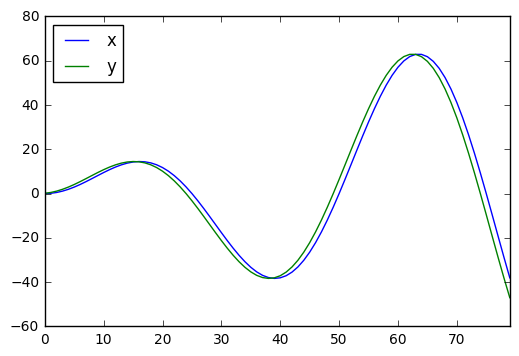

In [32]:
d = pd.DataFrame({"x": train_data[:80,0], "y": train_data[:80,1]})
d.head(80).plot()

In [24]:
make_mini_batch(train_data[0:60], 2, 4)

[[  0.00000000e+00   1.25333234e-01]
 [  1.25333234e-01   4.97379774e-01]
 [  4.97379774e-01   1.10437366e+00]
 [  1.10437366e+00   1.92701470e+00]
 [  1.92701470e+00   2.93892626e+00]
 [  2.93892626e+00   4.10728264e+00]
 [  4.10728264e+00   5.39359270e+00]
 [  5.39359270e+00   6.75462340e+00]
 [  6.75462340e+00   8.14344347e+00]
 [  8.14344347e+00   9.51056516e+00]
 [  9.51056516e+00   1.08051598e+01]
 [  1.08051598e+01   1.19763207e+01]
 [  1.19763207e+01   1.29743475e+01]
 [  1.29743475e+01   1.37520215e+01]
 [  1.37520215e+01   1.42658477e+01]
 [  1.42658477e+01   1.44772328e+01]
 [  1.44772328e+01   1.43535747e+01]
 [  1.43535747e+01   1.38692384e+01]
 [  1.38692384e+01   1.30063950e+01]
 [  1.30063950e+01   1.17557050e+01]
 [  1.17557050e+01   1.01168272e+01]
 [  1.01168272e+01   8.09874016e+00]
 [  8.09874016e+00   5.71986740e+00]
 [  5.71986740e+00   3.00799761e+00]
 [  3.00799761e+00  -8.04061325e-15]
 [ -8.04061325e-15  -3.25866407e+00]
 [ -3.25866407e+00  -6.71462695e+00]
 

(array([[[ -8.04061325e-15],
         [ -3.25866407e+00],
         [ -6.71462695e+00],
         [ -1.03074875e+01]],
 
        [[ -3.83092028e+01],
         [ -3.80422607e+01],
         [ -3.70979092e+01],
         [ -3.54617729e+01]]]), array([[-13.97085655],
        [-33.13206944]]))

In [6]:
# random seed fix
random.seed(0)
np.random.seed(0)
tf.set_random_seed(0)

In [7]:
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

In [1]:
with tf.Graph().as_default():
    input_ph      = tf.placeholder(tf.float32, [None, length_of_sequences, num_of_input_nodes], name="input")
    supervisor_ph = tf.placeholder(tf.float32, [None, num_of_output_nodes], name="supervisor")
#    istate_ph     = tf.placeholder(tf.float32, [None, num_of_hidden_nodes * 2], name="istate")

    with tf.name_scope("inference") as scope:
        weight1_var = tf.Variable(tf.truncated_normal([num_of_input_nodes, num_of_hidden_nodes], stddev=0.1), name="weight1")
        weight2_var = tf.Variable(tf.truncated_normal([num_of_hidden_nodes, num_of_output_nodes], stddev=0.1), name="weight2")
        bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
        bias2_var   = tf.Variable(tf.truncated_normal([num_of_output_nodes], stddev=0.1), name="bias2")
        
        weight1_hist = tf.histogram_summary("layer1/weights", weight1_var)
        weight2_hist = tf.histogram_summary("layer2/weights", weight2_var)
        bias1_hist = tf.histogram_summary("layer1/biases", bias1_var)
        bias2_hist = tf.histogram_summary("layer2/biases", bias2_var)
        
        in1 = tf.transpose(input_ph, [1, 0, 2])         # (batch, sequence, data) -> (sequence, batch, data)
        in2 = tf.reshape(in1, [-1, num_of_input_nodes]) # (sequence, batch, data) -> (sequence * batch, data)
        in3 = tf.matmul(in2, weight1_var) + bias1_var
        in4 = tf.split(0, length_of_sequences, in3)     # sequence * (batch, data)

        cell_layer1 = tf.nn.rnn_cell.BasicLSTMCell(num_of_hidden_nodes, forget_bias=forget_bias)
        cell_layer2 = tf.nn.rnn_cell.DropoutWrapper(
            tf.nn.rnn_cell.BasicLSTMCell(num_of_hidden_nodes, forget_bias=forget_bias))
        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell([cell_layer1, cell_layer2])
        state = stacked_lstm.zero_state(size_of_mini_batch, tf.float32)
        
#        rnn_output, states_op = tf.nn.rnn(stacked_lstm, in4, initial_state=istate_ph)
        rnn_output, states_op = tf.nn.rnn(stacked_lstm, in4, initial_state=state)
        output_op = tf.matmul(rnn_output[-1], weight2_var) + bias2_var

    with tf.name_scope("loss") as scope:
        square_error = tf.reduce_mean(tf.square(output_op - supervisor_ph))
        loss_op      = square_error
        tf.scalar_summary("loss", loss_op)

    with tf.name_scope("training") as scope:
        training_op = optimizer.minimize(loss_op)

    summary_op = tf.merge_all_summaries()
    init = tf.initialize_all_variables()

    with tf.Session() as sess:
        saver = tf.train.Saver()
        summary_writer = tf.train.SummaryWriter("data", graph=sess.graph)
        sess.run(init)

        for epoch in range(num_of_training_epochs):
            inputs, supervisors = make_mini_batch(train_data, size_of_mini_batch, length_of_sequences)

            train_dict = {
                input_ph:      inputs,
                supervisor_ph: supervisors,
#                istate_ph:     np.zeros((size_of_mini_batch, num_of_hidden_nodes * 2)),
            }
            sess.run(training_op, feed_dict=train_dict)

            if (epoch + 1) % 10 == 0:
                print(tf.shape(inputs))
                summary_str, train_loss = sess.run([summary_op, loss_op], feed_dict=train_dict)
                summary_writer.add_summary(summary_str, epoch)
                print("train#%d, train loss: %e" % (epoch + 1, train_loss))

        inputs  = make_prediction_initial(train_data, 0, length_of_initial_sequences)
        outputs = np.empty(0)
        states  = np.zeros((num_of_hidden_nodes * 2)),

        print("initial:", inputs)
        np.save("initial.npy", inputs)

        for epoch in range(num_of_prediction_epochs):
            pred_dict = {
                input_ph:  inputs.reshape((1, length_of_sequences, 1)),
#                istate_ph: states,
            }

#            output, states = sess.run([output_op, states_op], feed_dict=pred_dict)
            output = sess.run(output_op, feed_dict=pred_dict)
            print("prediction#%d, output: %f" % (epoch + 1, output))

            inputs  = np.delete(inputs, 0)
            inputs  = np.append(inputs, output)
            outputs = np.append(outputs, output)

        print("outputs:", outputs)
        np.save("output.npy", outputs)

        saver.save(sess, "data/model")

NameError: name 'tf' is not defined

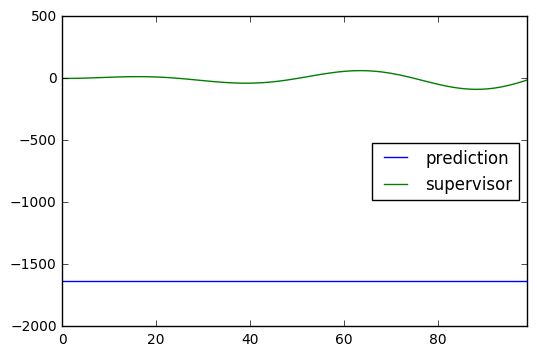

In [17]:
pred = np.load('output.npy')
df = pd.DataFrame({'supervisor': train_data[0:len(pred),0], 'prediction': pred})
df
df.plot()

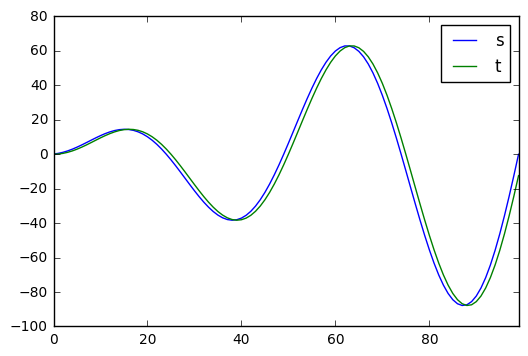

In [14]:
df = pd.DataFrame({'t': train_data[0:len(pred),0], 's': train_data[0:len(pred),1]})
df.head(600).plot()